## Can we predict and maximize article popularity on social media?
To find out, answer the following questions:
* Do title length, article length, or average length of words play a role in an article's popularity?
    * Hypothesis: Shorter articles with shorter titles and shorter words (simpler vocabulary) will garner more shares on average.
* Do certain genres lead to more popular articles? 
    * Hypothesis: Certain genres will receive more shares on average.
* What effect does the day of publication have?
    * Hypothesis: The day of publication will not have an impact on an article's shares.
* Do articles that skew positive, negative, or neutral perform better?
    * Hypothesis: More negative, outrageous (higher subjectivity) articles will be shared more on average.
* What effect do SEO terms have?
    * Hypothesis: Better performing SEO terms (keywords) will have a positive impact on an article's shares.
    
## Approach
Using UCI's [Online News Popularity Data Set](http://archive.ics.uci.edu/ml/datasets/Online+News+Popularity), I perform statistical tests to measure the significance of certain variables on the number of social media shares an article receives. During my exploratory data analysis, I create graphs that answer some of my objective questions. I then create a linear regression model, from which I can infer the strongest predictors based on the coefficients within the model.

## Cleaning and exploring the data
* Import the necessary libraries.

In [45]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')

import pickle

from functions import *
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

import warnings
warnings.filterwarnings('ignore')

# POSSIBLY
from collections import Counter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Import the data and take a look.

In [48]:
trees = pd.read_csv('data/2015StreetTreesCensus_TREES.csv')
trees.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,Latitude,longitude,x_sp,y_sp
0,08/27/2015,180683,348711,POINT (-73.84421521958048 40.723091773924274),3,0,OnCurb,Alive,Fair,Acer rubrum,...,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1.027431e+06,202756.768749
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
4,08/30/2015,189565,223043,POINT (-73.97597938483258 40.66677775537875),21,0,OnCurb,Alive,Good,Tilia americana,...,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,9.909138e+05,182202.425999


In [49]:
trees.shape

(683788, 42)

In [50]:
trees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   created_at  683788 non-null  object 
 1   tree_id     683788 non-null  int64  
 2   block_id    683788 non-null  int64  
 3   the_geom    683788 non-null  object 
 4   tree_dbh    683788 non-null  int64  
 5   stump_diam  683788 non-null  int64  
 6   curb_loc    683788 non-null  object 
 7   status      683788 non-null  object 
 8   health      652172 non-null  object 
 9   spc_latin   652169 non-null  object 
 10  spc_common  652169 non-null  object 
 11  steward     652173 non-null  object 
 12  guards      652172 non-null  object 
 13  sidewalk    652172 non-null  object 
 14  user_type   683788 non-null  object 
 15  problems    652124 non-null  object 
 16  root_stone  683788 non-null  object 
 17  root_grate  683788 non-null  object 
 18  root_other  683788 non-null  object 
 19  tr

In [51]:
trees.describe()

,tree_id,block_id,tree_dbh,stump_diam,zipcode,cb_num,borocode,cncldist,st_assem,st_senate,boro_ct,Latitude,longitude,x_sp,y_sp
count,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,683788.000000,6.837880e+05,683788.000000,683788.000000,6.837880e+05,683788.000000
mean,365205.011085,313793.096236,11.279787,0.432463,10916.246044,343.505404,3.358500,29.943181,50.791583,20.615781,3.404914e+06,40.701261,-73.924060,1.005280e+06,194798.424624
std,208122.092902,114839.024312,8.723042,3.290241,651.553364,115.740601,1.166746,14.328531,18.966520,7.390844,1.175863e+06,0.090311,0.123583,3.428505e+04,32902.061114
min,3.000000,100002.000000,0.000000,0.000000,83.000000,101.000000,1.000000,1.000000,23.000000,10.000000,1.000201e+06,40.498466,-74.254965,9.133493e+05,120973.792223
25%,186582.750000,221556.000000,4.000000,0.000000,10451.000000,302.000000,3.000000,19.000000,33.000000,14.000000,3.011700e+06,40.631928,-73.980500,9.896578e+05,169515.153719
50%,366214.500000,319967.000000,9.000000,0.000000,11214.000000,402.000000,4.000000,30.000000,52.000000,21.000000,4.008100e+06,40.700612,-73.912911,1.008386e+06,194560.252497
75%,546170.250000,404624.000000,16.000000,0.000000,11365.000000,412.000000,4.000000,43.000000,64.000000,25.000000,4.103202e+06,40.762228,-73.834910,1.029991e+06,217019.571916
max,722694.000000,999999.000000,450.000000,140.000000,11697.000000,503.000000,5.000000,51.000000,87.000000,36.000000,5.032300e+06,40.912918,-73.700488,1.067248e+06,271894.092088


* Rename some columns.

In [52]:
trees.columns = ['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist', 'st_assem',
       'st_senate', 'nta', 'nta_name', 'boro_ct', 'state', 'latitude',
       'longitude', 'x_sp', 'y_sp']

* Remove stumps and dead trees.

In [53]:
trees.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [54]:
# Get indices of dead trees and stumps
dead = trees[trees.status.isin(['Dead', 'Stump'])].index
 
# Delete these row indices from dataFrame
trees.drop(dead, inplace=True)

trees.shape

(652173, 42)

* Take a look at our target variable.

In [55]:
trees.health.value_counts()

Good    528850
Fair     96504
Poor     26818
Name: health, dtype: int64

In [56]:
trees.health.value_counts(normalize=True)

Good    0.810906
Fair    0.147973
Poor    0.041121
Name: health, dtype: float64

In [57]:
trees.boroname.value_counts()

Queens           237974
Brooklyn         169744
Staten Island    101443
Bronx             80585
Manhattan         62427
Name: boroname, dtype: int64

In [58]:
trees.groupby('boroname').health.value_counts(normalize=True)

boroname       health
Bronx          Good      0.826494
               Fair      0.135100
               Poor      0.038407
Brooklyn       Good      0.814238
               Fair      0.147711
               Poor      0.038051
Manhattan      Good      0.758614
               Fair      0.183574
               Poor      0.057812
Queens         Good      0.815249
               Fair      0.145180
               Poor      0.039572
Staten Island  Good      0.814939
               Fair      0.143284
               Poor      0.041778
Name: health, dtype: float64

In [53]:
trees.groupby('boroname').health.value_counts()

KeyError: 'boroname'

In [59]:
trees.user_type.value_counts()

TreesCount Staff    282259
Volunteer           207777
NYC Parks Staff     162137
Name: user_type, dtype: int64

* Look for NaN values.

In [60]:
trees.isna().sum()

created_at       0
tree_id          0
block_id         0
the_geom         0
tree_dbh         0
stump_diam       0
curb_loc         0
status           0
health           1
spc_latin        5
spc_common       5
steward          0
guards           1
sidewalk         1
user_type        0
problems        49
root_stone       0
root_grate       0
root_other       0
trunk_wire       0
trunk_light      0
trunk_other      0
branch_light     0
branch_shoe      0
branch_other     0
address          0
zipcode          0
zip_city         0
cb_num           0
borocode         0
boroname         0
council_dist     0
st_assem         0
st_senate        0
nta              0
nta_name         0
boro_ct          0
state            0
latitude         0
longitude        0
x_sp             0
y_sp             0
dtype: int64

* Replace NaNs in 'problems' column with 'None', in case we end up using that column.
* Drop the few rows with missing values for our target variable and species of tree.

In [61]:
trees.problems.fillna(value='None', inplace=True)

In [62]:
trees.dropna(how='any', axis=0, inplace=True)

* Create and pickle a dictionary of neighborhood codes and names, in case we want that later.

In [63]:
nta = list(trees['nta'].unique())

In [64]:
nta_name = list(trees['nta_name'].unique())

In [65]:
nta_dict = {k: v for k,v in zip(nta, nta_name)}
nta_dict

{'QN17': 'Forest Hills',
 'QN49': 'Whitestone',
 'BK90': 'East Williamsburg',
 'BK37': 'Park Slope-Gowanus',
 'MN14': 'Lincoln Square',
 'MN15': 'Clinton',
 'SI14': 'Grasmere-Arrochar-Ft. Wadsworth',
 'BK26': 'Gravesend',
 'QN72': 'Steinway',
 'SI54': 'Great Kills',
 'BK69': 'Clinton Hill',
 'BK81': 'Brownsville',
 'BK29': 'Bensonhurst East',
 'BK42': 'Flatbush',
 'QN25': 'Corona',
 'BK68': 'Fort Greene',
 'MN40': 'Upper East Side-Carnegie Hill',
 'MN12': 'Upper West Side',
 'SI25': 'Oakwood-Oakwood Beach',
 'QN60': 'Kew Gardens',
 'BK46': 'Ocean Parkway South',
 'MN27': 'Chinatown',
 'QN20': 'Ridgewood',
 'BX17': 'East Tremont',
 'SI36': 'Old Town-Dongan Hills-South Beach',
 'SI45': 'New Dorp-Midland Beach',
 'BK17': 'Sheepshead Bay-Gerritsen Beach-Manhattan Beach',
 'MN50': 'Stuyvesant Town-Cooper Village',
 'MN24': 'SoHo-TriBeCa-Civic Center-Little Italy',
 'SI24': 'Todt Hill-Emerson Hill-Heartland Village-Lighthous',
 'BK44': 'Madison',
 'QN62': 'Queensboro Hill',
 'SI01': "Annadal

In [66]:
with open('data/nta_dict.pickle', 'wb') as f:
    pickle.dump(nta_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

* Drop unnecessary columns.

In [67]:
trees.columns

Index(['created_at', 'tree_id', 'block_id', 'the_geom', 'tree_dbh',
       'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin', 'spc_common',
       'steward', 'guards', 'sidewalk', 'user_type', 'problems', 'root_stone',
       'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [68]:
drop_cols = ['created_at', 'block_id', 'the_geom', 'stump_diam', 'status', 'spc_latin', 'problems', 'address',
             'zipcode', 'zip_city', 'borocode', 'council_dist', 'st_assem', 'st_senate', 'nta_name', 'boro_ct',
             'state', 'latitude', 'longitude', 'x_sp', 'y_sp']
trees.drop(columns=drop_cols, inplace=True)
trees.set_index(['tree_id'], inplace=True)
trees.shape

(652166, 20)

In [69]:
trees.head()

,tree_dbh,curb_loc,health,spc_common,steward,guards,sidewalk,user_type,root_stone,root_grate,root_other,trunk_wire,trunk_light,trunk_other,branch_light,branch_shoe,branch_other,cb_num,boroname,nta
tree_id,,,,,,,,,,,,,,,,,,,,
180683,3,OnCurb,Fair,red maple,None,None,NoDamage,TreesCount Staff,No,No,No,No,No,No,No,No,No,406,Queens,QN17
200540,21,OnCurb,Fair,pin oak,None,None,Damage,TreesCount Staff,Yes,No,No,No,No,No,No,No,No,407,Queens,QN49
204026,3,OnCurb,Good,honeylocust,1or2,None,Damage,Volunteer,No,No,No,No,No,No,No,No,No,301,Brooklyn,BK90
204337,10,OnCurb,Good,honeylocust,None,None,Damage,Volunteer,Yes,No,No,No,No,No,No,No,No,301,Brooklyn,BK90
189565,21,OnCurb,Good,American linden,None,None,Damage,Volunteer,Yes,No,No,No,No,No,No,No,No,306,Brooklyn,BK37


### Dummy columns

In [70]:
trees.columns

Index(['tree_dbh', 'curb_loc', 'health', 'spc_common', 'steward', 'guards',
       'sidewalk', 'user_type', 'root_stone', 'root_grate', 'root_other',
       'trunk_wire', 'trunk_light', 'trunk_other', 'branch_light',
       'branch_shoe', 'branch_other', 'cb_num', 'boroname', 'nta'],
      dtype='object')

In [71]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [72]:
trees.sidewalk.unique()

array(['NoDamage', 'Damage'], dtype=object)

In [73]:
trees.user_type.unique()

array(['TreesCount Staff', 'Volunteer', 'NYC Parks Staff'], dtype=object)

In [74]:
# rename columns that we have to manually dummy, so the 0 and 1 make sense
trees.rename(columns={'curb_loc': 'on_curb', 'sidewalk': 'sidewalk_damage', 'user_type': 'pro_entry'}, inplace=True)

# trees on curb = 1; trees offset from curb = 0
trees.on_curb = np.where(trees.on_curb == 'OnCurb', 1, 0)
# damage to sidewalk near tree = 1; no sidewalk damage = 0
trees.sidewalk_damage = np.where(trees.sidewalk_damage == 'Damage', 1, 0)
# Professional staff (TreesCount & NYC Parks) = 1; volunteers = 0
trees.pro_entry = np.where(trees.pro_entry == 'Volunteer', 0, 1)

In [75]:
trees.branch_other.unique()

array(['No', 'Yes'], dtype=object)

* Reassign yes-no columns to 1s and 0s.

In [76]:
# create list of columns to dummy
yes_no_cols = ['root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
               'branch_light', 'branch_shoe', 'branch_other']

# call custom function
yes_to_one(trees, yes_no_cols)
# check to make sure it worked
trees.branch_other.unique()

array([0, 1])

* First rename a steward value that doesn't make sense (4 is accounted for twice, so renaming '4orMore' to '5plus').
* Create dummies for number of stewards, usefulness of tree guards, and borough name.
* Hold off on creating dummies for community board numbers and neighborhood codes.

In [77]:
trees['steward'] = np.where(trees.steward == '4orMore', '5plus', trees.steward)

In [78]:
trees.steward.unique()

array(['None', '1or2', '3or4', '5plus'], dtype=object)

In [79]:
trees.groupby('steward').health.value_counts(normalize=True)

steward  health
1or2     Good      0.803663
         Fair      0.152570
         Poor      0.043768
3or4     Good      0.813533
         Fair      0.147526
         Poor      0.038941
5plus    Good      0.845342
         Fair      0.124224
         Poor      0.030435
None     Good      0.812820
         Fair      0.146718
         Poor      0.040462
Name: health, dtype: float64

In [80]:
trees.guards.value_counts()

None       572300
Helpful     51866
Harmful     20252
Unsure       7748
Name: guards, dtype: int64

In [81]:
trees.groupby('guards').health.value_counts(normalize=True)

guards   health
Harmful  Good      0.756567
         Fair      0.189562
         Poor      0.053871
Helpful  Good      0.822080
         Fair      0.138164
         Poor      0.039756
None     Good      0.812464
         Fair      0.146991
         Poor      0.040545
Unsure   Good      0.763036
         Fair      0.177594
         Poor      0.059370
Name: health, dtype: float64

In [82]:
trees.boroname.unique()

array(['Queens', 'Brooklyn', 'Manhattan', 'Staten Island', 'Bronx'],
      dtype=object)

In [83]:
dummy_cols = ['steward', 'guards', 'boroname']

In [84]:
tree_dummies = pd.get_dummies(trees[dummy_cols])
tree_dummies.columns

Index(['steward_1or2', 'steward_3or4', 'steward_5plus', 'steward_None',
       'guards_Harmful', 'guards_Helpful', 'guards_None', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn', 'boroname_Manhattan',
       'boroname_Queens', 'boroname_Staten Island'],
      dtype='object')

In [85]:
dummy_cols.extend(['steward_None', 'guards_None', 'boroname_Staten Island'])
trees = pd.concat([trees,tree_dummies], axis=1)
trees.drop(columns=dummy_cols, axis=1, inplace=True)

In [86]:
trees.columns

Index(['tree_dbh', 'on_curb', 'health', 'spc_common', 'sidewalk_damage',
       'pro_entry', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'nta', 'steward_1or2', 'steward_3or4',
       'steward_5plus', 'guards_Harmful', 'guards_Helpful', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn', 'boroname_Manhattan',
       'boroname_Queens'],
      dtype='object')

In [87]:
trees.head()

,tree_dbh,on_curb,health,spc_common,sidewalk_damage,pro_entry,root_stone,root_grate,root_other,trunk_wire,...,steward_1or2,steward_3or4,steward_5plus,guards_Harmful,guards_Helpful,guards_Unsure,boroname_Bronx,boroname_Brooklyn,boroname_Manhattan,boroname_Queens
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3,1,Fair,red maple,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
200540,21,1,Fair,pin oak,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
204026,3,1,Good,honeylocust,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
204337,10,1,Good,honeylocust,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
189565,21,1,Good,American linden,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## SAVE A COPY

In [88]:
trees.to_csv('data/nyc_trees_2015.csv')

In [3]:
trees = pd.read_csv('data/nyc_trees_2015.csv', index_col=0)
trees.head()

,tree_dbh,on_curb,health,spc_common,sidewalk_damage,pro_entry,root_stone,root_grate,root_other,trunk_wire,...,steward_1or2,steward_3or4,steward_5plus,guards_Harmful,guards_Helpful,guards_Unsure,boroname_Bronx,boroname_Brooklyn,boroname_Manhattan,boroname_Queens
tree_id,,,,,,,,,,,,,,,,,,,,,
180683,3,1,Fair,red maple,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
200540,21,1,Fair,pin oak,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
204026,3,1,Good,honeylocust,1,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
204337,10,1,Good,honeylocust,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
189565,21,1,Good,American linden,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
trees.tree_dbh.describe()

count    652166.000000
mean         11.709479
std           8.634194
min           0.000000
25%           5.000000
50%          10.000000
75%          16.000000
max         425.000000
Name: tree_dbh, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e0746a0>]],
      dtype=object)

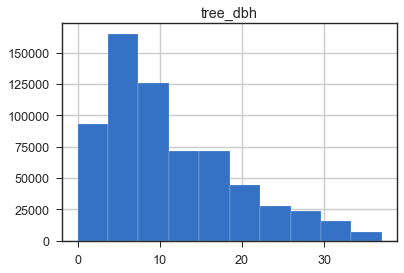

In [9]:
trees[trees.tree_dbh <= 37].hist('tree_dbh', bins=10)

In [13]:
trees[trees.tree_dbh == 425]

,tree_dbh,on_curb,health,spc_common,sidewalk_damage,pro_entry,root_stone,root_grate,root_other,trunk_wire,...,steward_1or2,steward_3or4,steward_5plus,guards_Harmful,guards_Helpful,guards_Unsure,boroname_Bronx,boroname_Brooklyn,boroname_Manhattan,boroname_Queens
tree_id,,,,,,,,,,,,,,,,,,,,,
168583,425,1,Good,swamp white oak,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [14]:
trees.nta.value_counts()

SI01    12530
SI54    10267
QN46     9386
BK82     9188
SI32     8842
        ...  
MN06      865
BX46      773
BK93      671
BK23      455
MN50      438
Name: nta, Length: 188, dtype: int64

In [16]:
with open('data/nta_dict.pickle', 'rb') as f:
    nta_dict = pickle.load(f)

In [22]:
nta_dict['QN46']

'Bayside-Bayside Hills'

In [32]:
trees.columns

Index(['tree_dbh', 'on_curb', 'health', 'spc_common', 'sidewalk_damage',
       'pro_entry', 'root_stone', 'root_grate', 'root_other', 'trunk_wire',
       'trunk_light', 'trunk_other', 'branch_light', 'branch_shoe',
       'branch_other', 'cb_num', 'nta', 'steward_1or2', 'steward_3or4',
       'steward_5plus', 'guards_Harmful', 'guards_Helpful', 'guards_Unsure',
       'boroname_Bronx', 'boroname_Brooklyn', 'boroname_Manhattan',
       'boroname_Queens'],
      dtype='object')

## Vanilla models

In [23]:
df_van = trees.copy()

In [33]:
X_van = df_van.drop(columns=['health', 'spc_common', 'nta'], axis=1)
y_van = df_van['health']

In [34]:
X_train_van, X_test_van, y_train_van, y_test_van = train_test_split(X_van, y_van, random_state=42, stratify=y_van)

### Resample

In [56]:
# concatenate our training data back together
training  = pd.concat([X_train_van, y_train_van], axis=1)

In [57]:
# separate minority and majority classes
good = training[training.health=='Good']
fair = training[training.health=='Fair']
poor = training[training.health=='Poor']

In [58]:
# Get a class count to understand the class imbalance.
print('good count: '+ str(len(good)))
print('fair count: '+ str(len(fair)))
print('poor count: '+ str(len(poor)))

good count: 396633
fair count: 72378
poor count: 20113


In [62]:
# downsample majority
good_downsampled = resample(good,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

# downsample majority
fair_downsampled = resample(fair,
                                replace = False, # sample without replacement
                                n_samples = len(poor), # match minority n
                                random_state = 42) # reproducible results

In [63]:
# combine minority and downsampled majority
downsampled = pd.concat([good_downsampled, fair_downsampled, poor])

# checking counts
downsampled.health.value_counts()

Good    20113
Poor    20113
Fair    20113
Name: health, dtype: int64

In [68]:
# trying logistic regression again with the balanced dataset
y_train_down = downsampled.health
X_train_down = downsampled.drop('health', axis=1)


# downsampled_dt = DecisionTreeClassifier(max_depth=5)
downsampled_lr = LogisticRegression(class_weight='balanced', multi_class='multinomial')


# downsampled_dt.fit(X_train, y_train)
downsampled_lr.fit(X_train_down, y_train_down)

# downsampled_pred = upsampled_dt.predict(X_test)
downsampled_pred = downsampled_lr.predict(X_test_van)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test_van, downsampled_pred))

# checking accuracy
print('Test F1 score: ', f1_score(y_test_van, downsampled_pred, average='weighted'))

Test Accuracy score:  0.4996933305528637
Test F1 score:  0.5775269981557326


In [35]:
# params_knn = {
#     'n_neighbors': range(1,21,2),
#     'weights': ['uniform', 'distance'],
# #     'algorithm': ['ball_tree', 'kd_tree', 'brute'],
#     'p': range(1,4)
# }

In [38]:
# CV_knn_van = GridSearchCV(KNeighborsClassifier(), params_knn, n_jobs=-1, scoring='accuracy', verbose=1)

# CV_knn_van.fit(X_train_van, y_train_van)

In [39]:
# ### Identify the best params 
# print(CV_knn_van.best_estimator_)

# #Identify the best score during fitting with cross-validation
# print(CV_knn_van.best_score_)

In [40]:
# #predict on the test set
# y_pred_knn_van = CV_knn_van.best_estimator_.predict(X_test_van)

# # checking metrics
# print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_knn_van))
# print('Test Precision score: ', precision_score(y_test_van, y_pred_knn_van))
# print('Test Recall score: ', recall_score(y_test_van, y_pred_knn_van))
# print('Test F1 score: ', f1_score(y_test_van, y_pred_knn_van))

In [41]:
param_grid = { 
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.0001, .001, .01, .1, 1.0, 10.0, 100.0],
    'solver': ['sag', 'saga', 'liblinear'],
}

In [47]:
van_weight = LogisticRegression(class_weight='balanced', multi_class='multinomial')
van_weight.fit(X_train_van, y_train_van)

#predict on the test set
y_pred_van_weight = van_weight.predict(X_test_van)

In [52]:
# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight, average='weighted'))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight, average='weighted'))

Test Accuracy score:  0.48177770145115983
Test Precision score:  0.7187596430706891
Test Recall score:  0.48177770145115983
Test F1 score:  0.563293712635807


In [42]:
#create a grid search object and fit it to the data
CV_van_weight = GridSearchCV(LogisticRegression(class_weight='balanced'),
                      param_grid, n_jobs=-1, scoring='accuracy', verbose=2)

CV_van_weight.fit(X_train_van, y_train_van)

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [ ]:
### Identify the best params 
print(CV_van_weight.best_estimator_)

#Identify the best score during fitting with cross-validation
print(CV_van_weight.best_score_)

In [ ]:
#predict on the test set
y_pred_van_weight = CV_van_weight.best_estimator_.predict(X_test_van)

# checking metrics
print('Test Accuracy score: ', accuracy_score(y_test_van, y_pred_van_weight))
print('Test Precision score: ', precision_score(y_test_van, y_pred_van_weight))
print('Test Recall score: ', recall_score(y_test_van, y_pred_van_weight))
print('Test F1 score: ', f1_score(y_test_van, y_pred_van_weight))

In [276]:
trees[trees.nta == 'QN17'].iloc[:, 10:].head()

,root_other,trunk_wire,trunk_light,trunk_other,branch_light,branch_shoe,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta
tree_id,,,,,,,,,,,,,
180683,0,0,0,0,0,0,0,406,Queens,29,28,16,QN17
203550,0,0,0,0,1,0,0,406,Queens,29,28,15,QN17
193183,0,0,0,0,0,0,0,406,Queens,29,28,15,QN17
203577,0,0,0,0,1,0,0,406,Queens,29,28,15,QN17
203386,0,0,0,0,1,0,0,406,Queens,29,28,15,QN17


In [278]:
print(len(trees.cb_num.unique()))
trees.cb_num.unique()

59


array([406, 407, 301, 306, 107, 104, 502, 313, 401, 503, 302, 316, 311,
       314, 404, 307, 108, 409, 312, 103, 405, 206, 315, 106, 102, 205,
       105, 109, 403, 207, 310, 317, 414, 304, 413, 308, 212, 408, 411,
       318, 208, 101, 110, 402, 412, 204, 211, 410, 305, 203, 303, 209,
       501, 210, 309, 201, 112, 111, 202])

In [282]:
print(len(trees.nta.unique()))
trees.nta.unique()

188


array(['QN17', 'QN49', 'BK90', 'BK37', 'MN14', 'MN15', 'SI14', 'BK26',
       'QN72', 'SI54', 'BK69', 'BK81', 'BK29', 'BK42', 'QN25', 'BK68',
       'MN40', 'MN12', 'SI25', 'QN60', 'BK46', 'MN27', 'QN20', 'BX17',
       'SI36', 'SI45', 'BK17', 'MN50', 'MN24', 'SI24', 'BK44', 'QN62',
       'SI01', 'BX06', 'BX41', 'SI48', 'MN20', 'MN23', 'BK33', 'MN09',
       'QN28', 'BX43', 'BX36', 'BK19', 'BK31', 'BK43', 'QN51', 'BK96',
       'QN22', 'QN15', 'BK77', 'QN12', 'BX40', 'QN03', 'QN18', 'QN34',
       'BK64', 'BK28', 'BK95', 'BX62', 'QN27', 'MN31', 'QN70', 'MN21',
       'QN53', 'QN10', 'BK41', 'QN41', 'QN48', 'BK76', 'SI05', 'BX28',
       'BK58', 'BK25', 'MN17', 'QN19', 'MN25', 'MN11', 'QN31', 'BK88',
       'QN08', 'QN66', 'QN46', 'QN42', 'QN06', 'QN23', 'BX01', 'MN19',
       'BX26', 'QN45', 'BK61', 'BK73', 'BX49', 'QN71', 'QN57', 'BK82',
       'BK78', 'BK79', 'BK60', 'MN28', 'MN13', 'BK34', 'BK75', 'BX08',
       'QN54', 'SI07', 'BX52', 'BK45', 'MN32', 'BX03', 'QN50', 'BK35',
      

In [274]:
trees.iloc[:, 10:].head(10)

,root_other,trunk_wire,trunk_light,trunk_other,branch_light,branch_shoe,branch_other,cb_num,boroname,council_dist,st_assem,st_senate,nta
tree_id,,,,,,,,,,,,,
180683,0,0,0,0,0,0,0,406,Queens,29,28,16,QN17
200540,0,0,0,0,0,0,0,407,Queens,19,27,11,QN49
204026,0,0,0,0,0,0,0,301,Brooklyn,34,50,18,BK90
204337,0,0,0,0,0,0,0,301,Brooklyn,34,53,18,BK90
189565,0,0,0,0,0,0,0,306,Brooklyn,39,44,21,BK37
190422,0,0,0,0,0,0,0,107,Manhattan,3,67,27,MN14
190426,0,0,0,0,0,0,0,107,Manhattan,3,67,27,MN14
208649,0,0,0,0,0,0,0,104,Manhattan,3,75,27,MN15
209610,0,0,0,0,0,0,0,502,Staten Island,50,64,23,SI14


In [181]:
trees.spc_common.value_counts().head(10).keys()

Index(['London planetree', 'honeylocust', 'Callery pear', 'pin oak',
       'Norway maple', 'littleleaf linden', 'cherry', 'Japanese zelkova',
       'ginkgo', 'Sophora'],
      dtype='object')

In [183]:
trees_most_pop = trees[trees.spc_common.isin(['London planetree', 'honeylocust', 'Callery pear', 'pin oak',
       'Norway maple', 'littleleaf linden', 'cherry', 'Japanese zelkova',
       'ginkgo', 'Sophora'])]
trees_most_pop.head()

,created_at,tree_id,block_id,the_geom,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
1,09/03/2015,200540,315986,POINT (-73.81867945834878 40.79411066708779),21,0,OnCurb,Alive,Fair,Quercus palustris,...,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1.034456e+06,228644.837379
2,09/05/2015,204026,218365,POINT (-73.93660770459083 40.717580740099116),3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1.001823e+06,200716.891267
3,09/05/2015,204337,217969,POINT (-73.93445615919741 40.713537494833226),10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1.002420e+06,199244.253136
5,08/30/2015,190422,106099,POINT (-73.98494997200308 40.770045625891846),11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,67,27,MN14,Lincoln Square,1014500,New York,40.770046,-73.984950,9.884187e+05,219825.522669
6,08/30/2015,190426,106099,POINT (-73.98533807200513 40.77020969000546),11,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,...,67,27,MN14,Lincoln Square,1014500,New York,40.770210,-73.985338,9.883112e+05,219885.278455


In [ ]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack()

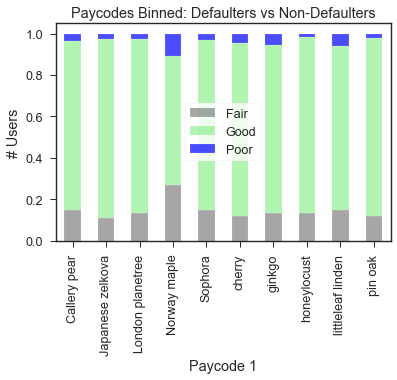

In [199]:
# print('Paycode 1 Summary')

# print('\n')
# print(df_train.groupby(['pay_1_bin','default']).pay_1_bin.count().unstack())

# Passenger class visualization
species_health = trees_most_pop.groupby('spc_common').health.value_counts(normalize=True).unstack().head(10)
p1 = species_health.plot(kind = 'bar', stacked = True, 
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Paycode 1')
p1.set_ylabel('# Users')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

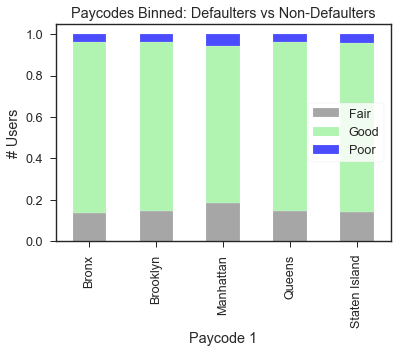

In [196]:
boros = trees.groupby(['boroname']).health.value_counts(normalize=True).unstack()
p1 = boros.plot(kind = 'bar', stacked = True, 
                   title = 'Paycodes Binned: Defaulters vs Non-Defaulters', 
                   color = ['grey','lightgreen', 'blue'], alpha = .70)
p1.set_xlabel('Paycode 1')
p1.set_ylabel('# Users')
p1.legend(['Fair','Good', 'Poor'])
plt.show()

In [85]:
trees[trees.spc_common == 'London planetree'].health.value_counts(normalize=True)

Good    0.84252
Fair    0.13222
Poor    0.02526
Name: health, dtype: float64

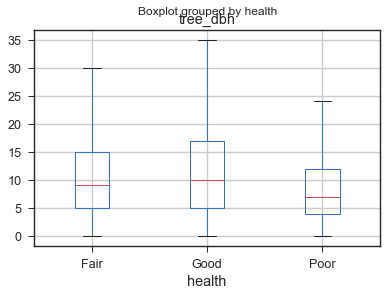

In [203]:
trees.boxplot('tree_dbh', 'health', showfliers=False)

In [76]:
trees.groupby('spc_common').health.value_counts(normalize=True)

spc_common              health
'Schubert' chokecherry  Good      0.803805
                        Fair      0.146686
                        Poor      0.049509
American beech          Good      0.783883
                        Fair      0.139194
                                    ...   
white pine              Fair      0.178218
                        Poor      0.054455
willow oak              Good      0.855842
                        Fair      0.113065
                        Poor      0.031093
Name: health, Length: 392, dtype: float64

In [69]:
trees.columns

Index(['created_at', 'the_geom', 'tree_dbh', 'stump_diam', 'curb_loc',
       'status', 'health', 'spc_latin', 'spc_common', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [70]:
trees.trunk_light.unique()

array(['No', 'Yes'], dtype=object)

In [89]:
trees.problems.value_counts()

None                                                                    426280
Stones                                                                   95673
BranchLights                                                             29452
Stones,BranchLights                                                      17808
RootOther                                                                11418
                                                                         ...  
Stones,RootOther,TrunkOther,BranchLights,Sneakers                            1
Stones,RootOther,TrunkLights,BranchLights,BranchOther                        1
MetalGrates,WiresRope,TrunkLights,BranchLights,BranchOther                   1
MetalGrates,RootOther,WiresRope,TrunkLights,BranchLights,BranchOther         1
MetalGrates,TrunkLights,TrunkOther,BranchOther                               1
Name: problems, Length: 232, dtype: int64

In [105]:
trees.shape

(652166, 40)

In [106]:
trees.columns

Index(['created_at', 'the_geom', 'tree_dbh', 'stump_diam', 'curb_loc',
       'status', 'health', 'spc_latin', 'spc_common', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'root_stone', 'root_grate',
       'root_other', 'trunk_wire', 'trunk_light', 'trunk_other',
       'branch_light', 'branch_shoe', 'branch_other', 'address', 'zipcode',
       'zip_city', 'cb_num', 'borocode', 'boroname', 'council_dist',
       'st_assem', 'st_senate', 'nta', 'nta_name', 'boro_ct', 'state',
       'latitude', 'longitude', 'x_sp', 'y_sp'],
      dtype='object')

In [113]:
len(trees.council_dist.unique())

51

In [118]:
len(trees.tree_dbh.unique())

145

In [19]:
len(trees.block_id.unique())

101390

In [28]:
trees.health.value_counts()

Good    528850
Fair     96504
Poor     26818
Name: health, dtype: int64

In [87]:
trees.health.value_counts(normalize=True)

Good    0.810906
Fair    0.147973
Poor    0.041121
Name: health, dtype: float64

In [29]:
trees.health.isna().sum()

31616

In [32]:
trees.status.value_counts()

Alive    652173
Stump     17654
Dead      13961
Name: status, dtype: int64

In [31]:
trees[trees.health.isna()].head(20)

,tree_id,block_id,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,...,branch_other,zipcode,cb_num,borocode,council_dist,st_assem,st_senate,nta,latitude,longitude
630,192569,302968,2,0,OnCurb,Dead,NaN,NaN,NaN,NaN,...,No,11377,402,4,26,37,12,QN31,40.738044,-73.921552
631,179766,230466,0,30,OnCurb,Stump,NaN,NaN,NaN,NaN,...,No,11210,314,3,45,42,21,BK42,40.637379,-73.953814
634,180619,348834,0,10,OnCurb,Stump,NaN,NaN,NaN,NaN,...,No,11375,406,4,29,27,15,QN17,40.725300,-73.839376
635,184295,505610,0,0,OnCurb,Dead,NaN,NaN,NaN,NaN,...,No,10458,206,2,15,78,33,BX06,40.857876,-73.887850
636,208828,107238,0,15,OnCurb,Stump,NaN,NaN,NaN,NaN,...,No,10065,108,1,5,76,28,MN31,40.764914,-73.960857
637,179748,348463,20,0,OnCurb,Dead,NaN,NaN,NaN,NaN,...,No,11375,406,4,29,27,14,QN17,40.721514,-73.836307
639,181973,337808,0,25,OnCurb,Stump,NaN,NaN,NaN,NaN,...,No,11694,414,4,32,23,15,QN10,40.571331,-73.858072
727,184110,504234,3,0,OnCurb,Dead,NaN,NaN,NaN,NaN,...,No,10457,205,2,15,86,33,BX41,40.852625,-73.900171
729,191466,310454,19,0,OnCurb,Dead,NaN,NaN,NaN,NaN,...,No,11415,409,4,29,28,14,QN60,40.712993,-73.831434
730,200522,210288,0,17,OnCurb,Stump,NaN,NaN,NaN,NaN,...,No,11229,315,3,46,41,22,BK44,40.604037,-73.937835


In [38]:
trees.columns

Index(['tree_dbh', 'stump_diam', 'curb_loc', 'status', 'health', 'spc_latin',
       'spc_common', 'steward', 'guards', 'sidewalk', 'user_type', 'problems',
       'root_stone', 'root_grate', 'root_other', 'trunk_wire', 'trunk_light',
       'trunk_other', 'branch_light', 'branch_shoe', 'branch_other', 'zipcode',
       'cb_num', 'borocode', 'council_dist', 'st_assem', 'st_senate', 'nta',
       'latitude', 'longitude'],
      dtype='object')

In [37]:
trees.curb_loc.unique()

array(['OnCurb', 'OffsetFromCurb'], dtype=object)

In [39]:
trees.borocode.value_counts()

4    237974
3    169744
5    101443
2     80585
1     62427
Name: borocode, dtype: int64

In [ ]:
trees.drop(columns=['status'], axis=1)